In [1]:
import os

# import healpy as hp
import numpy as np
import skyproj
# import proplot as pplt
import matplotlib.pyplot as plt
import fitsio

import rubin_sim
from rubin_sim import maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
# from rubin_sim.utils import raDec2Hpid

In [2]:
from rubin_sim import maf

In [3]:
def mad(x, axis=None, no_scale=False):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis: int
        axis over which to take mode (default: None)
    no_scale: bool
        return MAD not scaled to match a Gaussian (default: False)

    Returns
    -------
    mad: float
        MAD of array x
    """
    kd = True if axis is not None else False
    mad = np.median(np.abs(x - np.median(x, axis=axis, keepdims=kd)), axis=axis)
    if no_scale:
        return mad
    else:
        return 1.4826 * mad

In [4]:
nside = 128

sm = SkyAreaGenerator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'virgo'))[0]

In [5]:
def compute_map_stats(maps_arr, noroll_maps_arr):

    # msk = maps_arr < 0
    # maps_arr[msk] = 0

    # msk = noroll_maps_arr < 0
    # noroll_maps_arr[msk] = 0
    
    mdata = np.zeros(
        len(maps_arr),
        dtype=[
            (col, "f8", (2,))
            for col in [
                "med",
                "sd",
                "pt",
                "area",
            ]
        ] + [
            (col, "f8")
            for col in ["tlost", "alost"]
        ],
    )
    
    for i in range(len(maps_arr)):
        
        fmaps = maps_arr[i].copy()
        fmaps[~wfd_indx] = -9999
        fmaps = fmaps[fmaps > 15]
        if fmaps.shape == (0,):
            continue
        
        fnoroll_maps = noroll_maps_arr[i].copy()
        fnoroll_maps[~wfd_indx] = -9999        
        fnoroll_maps = fnoroll_maps[fnoroll_maps > 15]

        if fnoroll_maps.shape == (0,):
            continue
            
        mdata["med"][i, 0] = np.median(fmaps)
        mdata["med"][i, 1] = np.median(fnoroll_maps)

        mdata["sd"][i, 0] = mad(fmaps)
        mdata["sd"][i, 1] = mad(fnoroll_maps)
        
        ptval = 25
        mdata["pt"][i, 0] = np.percentile(fmaps, [ptval])
        mdata["pt"][i, 1] = np.percentile(fnoroll_maps, [ptval])
        
        mdata["tlost"][i] = (mdata["pt"][i, 1] - mdata["pt"][i, 0])/mdata["pt"][i, 1]

        ns = 3
        mn = np.median(fnoroll_maps)
        _sd = mad(fnoroll_maps)
        cut = mn-ns*_sd
        cut = mdata["pt"][i, 1]
        mdata["area"][i, 0] = np.sum(fmaps > cut)
        mdata["area"][i, 1] = np.sum(fnoroll_maps > cut)
        mdata["alost"][i] = (
            (mdata["area"][i, 1] - mdata["area"][i, 0])/mdata["area"][i, 1]
        )

    return mdata

In [6]:
noroll_maps_arr = fitsio.read("noroll_v3.3_10yrs_nside128_bins40.fits")
baseline_maps_arr = fitsio.read("rolling_phased_ps_0_v3.3_10yrs_nside128_bins40.fits")

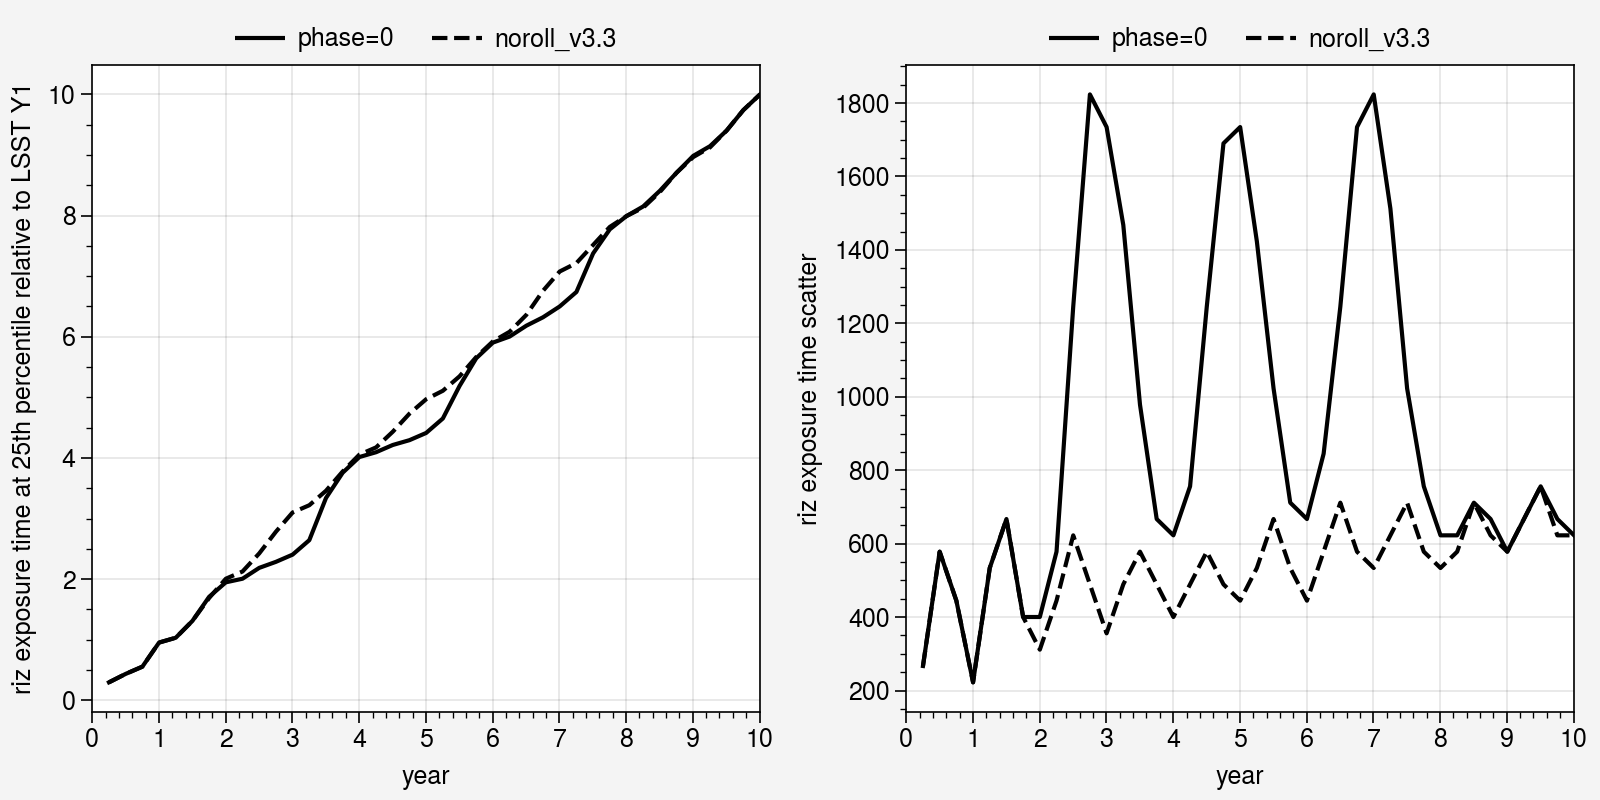

In [7]:
import proplot as pplt
import glob

alpha = 1

rlabel = "phase=0"
nrlabel = "noroll_v3.3"

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharey=0, sharex=0)

maps_arr = baseline_maps_arr.copy()
i = 0
mdata = compute_map_stats(maps_arr, noroll_maps_arr)

xy = np.linspace(0, 3653, 41)[1:]/365

#     axs[0, 0].plot(xy, mdata["tlost"], 'k', label="depth" if i == 0 else None, alpha=alpha)
#     axs[0, 0].plot(xy, mdata["alost"], 'k--', label="area" if i == 0 else None, alpha=alpha)
#     axs[0, 0].set_ylabel("frac depth or area lost at 25th percentile")
#     if i == 0:
#         axs[0, 0].legend(loc='t', frameon=False)

axs[0].plot(
    xy, 
    mdata["pt"][:, 0]/(mdata["pt"][-1, 0]/10), 
    'k', 
    label=rlabel if i == 0 else None,
    alpha=alpha,
)
#     if i == 0:
#         axs[0].plot(
#             [0, 10], 
#             [0, 10], 
#             'k:', 
#             label="uniform" if i == 0 else None,
#         )
if i == 0:
    axs[0].plot(xy, mdata["pt"][:, 1]/(mdata["pt"][-1, 1]/10), 'k--', label=nrlabel if i == 0 else None)
axs[0].set_ylabel("riz exposure time at 25th percentile relative to LSST Y1")
if i == 0:
    axs[0].legend(loc="t", frameon=False)

#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

axs[1].plot(xy, mdata["sd"][:, 0], 'k', label=rlabel if i == 0 else None, alpha=alpha)
if i == 0:
    axs[1].plot(xy, mdata["sd"][:, 1], 'k--', label=nrlabel if i == 0 else None)
axs[1].set_ylabel("riz exposure time scatter")
if i == 0:
    axs[1].legend(loc="t", frameon=False)

for ax in axs:
    ax.set_xlim(0, 10)
    ax.set_xlabel("year")
    ax.format(xticks=np.arange(0, 11))

fig.savefig(rlabel + ".png", dpi=300)

### Check Phased Rolling

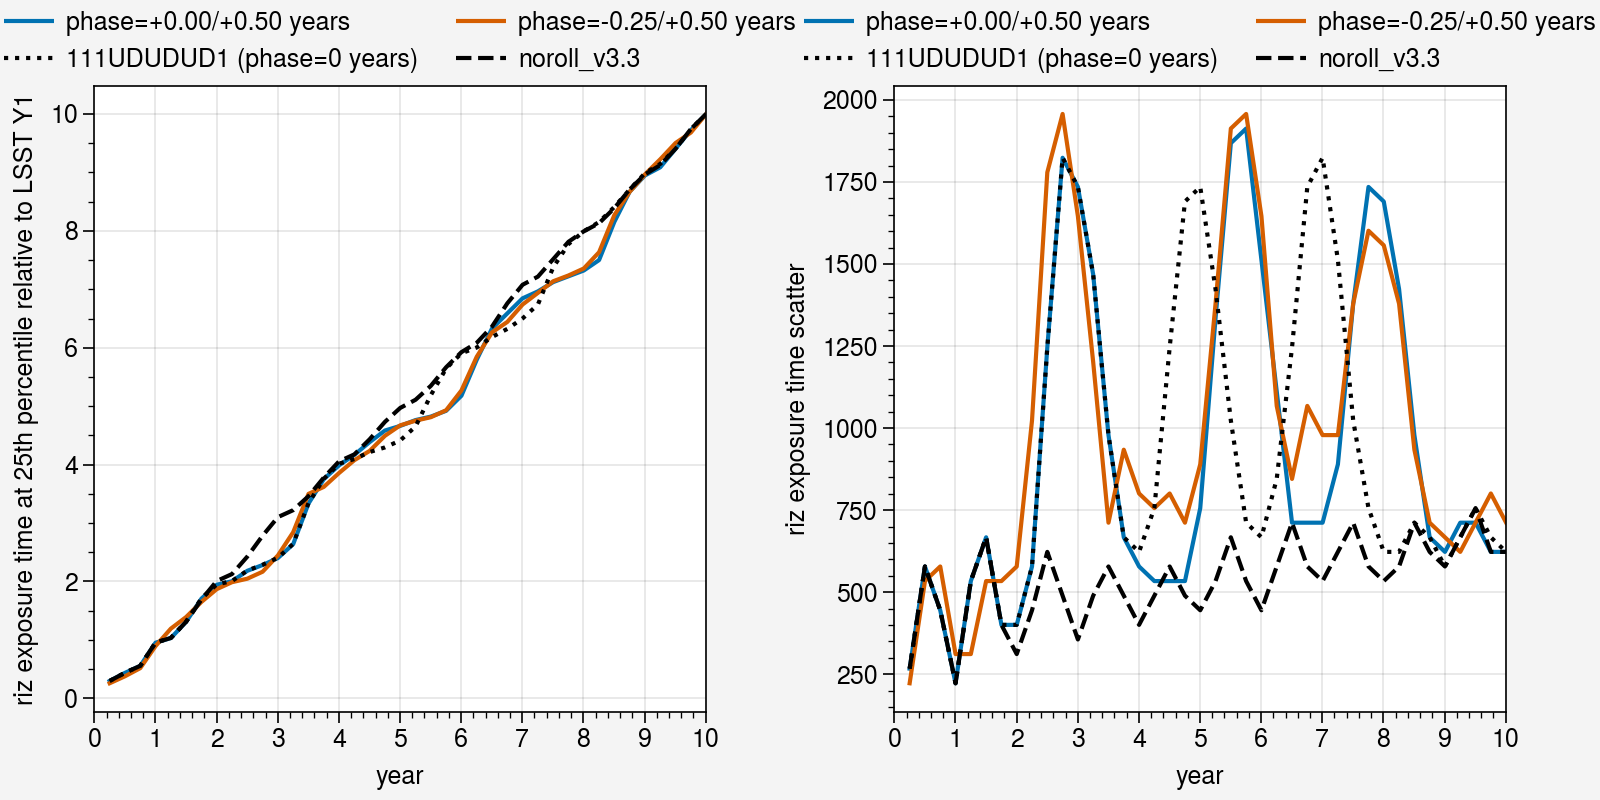

In [15]:
import proplot as pplt
import glob

alpha = 1

rlabel = "111UDUDUD1 (phase=0 years)"
nrlabel = "noroll_v3.3"
bl_mdata = compute_map_stats(baseline_maps_arr.copy(), noroll_maps_arr)


fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharey=0, sharex=0)


fnames = [
    "rolling_phased_ps_182_v3.3_10yrs_nside128_bins40.fits",
    "rolling_phased_ps_182_psf_-91_v3.3_10yrs_nside128_bins40.fits",
    # "rolling_phased_ps_182_psf_91_v3.3_10yrs_nside128_bins40.fits",
    # "rolling_phased_ps_-182_v3.3_10yrs_nside128_bins40.fits",
]
names = [
    "phase=+0.00/+0.50 years", 
    "phase=-0.25/+0.50 years",
    # "phase=+0.25/+0.50 years",
    # "phase=-0.5 years",
]
for i, fname in enumerate(fnames):
    maps_arr = fitsio.read(fname)
    mdata = compute_map_stats(maps_arr, noroll_maps_arr)
    name = names[i]

    xy = np.linspace(0, 3653, 41)[1:]/365
    
#     axs[0, 0].plot(xy, mdata["tlost"], 'k', label="depth" if i == 0 else None, alpha=alpha)
#     axs[0, 0].plot(xy, mdata["alost"], 'k--', label="area" if i == 0 else None, alpha=alpha)
#     axs[0, 0].set_ylabel("frac depth or area lost at 25th percentile")
#     if i == 0:
#         axs[0, 0].legend(loc='t', frameon=False)

    axs[0].plot(
        xy, 
        mdata["pt"][:, 0]/(mdata["pt"][-1, 0]/10),
        label=name,
        alpha=alpha,
    )
#     if i == 0:
#         axs[0].plot(
#             [0, 10], 
#             [0, 10], 
#             'k:', 
#             label="uniform" if i == 0 else None,
#         )
    if i == len(fnames)-1:
        axs[0].plot(xy, bl_mdata["pt"][:, 0]/(bl_mdata["pt"][-1, 0]/10), 'k:', label=rlabel)
        axs[0].plot(xy, mdata["pt"][:, 1]/(mdata["pt"][-1, 1]/10), 'k--', label=nrlabel)
        axs[0].set_ylabel("riz exposure time at 25th percentile relative to LSST Y1")
        axs[0].legend(loc="t", frameon=False, ncol=2)

#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

    axs[1].plot(xy, mdata["sd"][:, 0], label=name, alpha=alpha)
    if i == len(fnames)-1:
        axs[1].plot(xy, bl_mdata["sd"][:, 0], 'k:', label=rlabel)
        axs[1].plot(xy, mdata["sd"][:, 1], 'k--', label=nrlabel)
    axs[1].set_ylabel("riz exposure time scatter")
    if i == len(fnames)-1:
        axs[1].legend(loc="t", frameon=False, ncol=2)

    for ax in axs:
        ax.set_xlim(0, 10)
        ax.set_xlabel("year")
        ax.format(xticks=np.arange(0, 11))
        
fig.savefig("roll_with_phases.png", dpi=300)

## Plot the Maps

In [ ]:
sp.draw_hpxmap

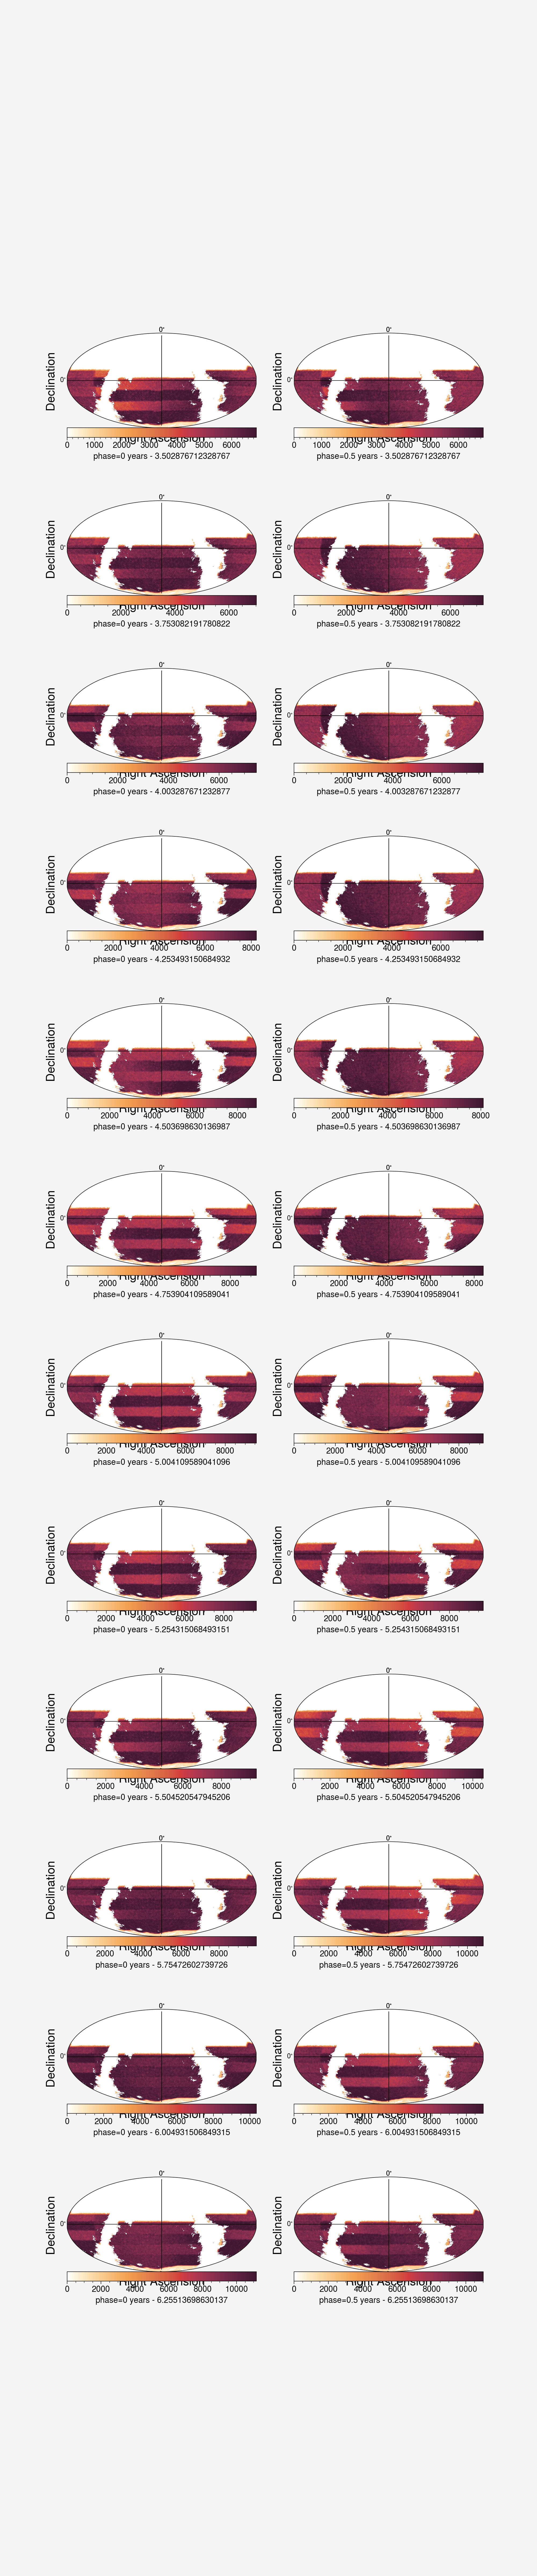

In [18]:
bs_maps_arr = fitsio.read("rolling_phased_ps_0_v3.3_10yrs_nside128_bins40.fits")
maps_arr = fitsio.read("rolling_phased_ps_182_psf_-91_v3.3_10yrs_nside128_bins40.fits")

if True:
    msk = maps_arr < 0
    maps_arr[msk] = 0
    # maps_arr = np.cumsum(maps_arr, axis=0)
    
    msk = bs_maps_arr < 0
    bs_maps_arr[msk] = 0
    # bs_maps_arr = np.cumsum(bs_maps_arr, axis=0)

# fig, axs = pplt.subplots(nrows=4, ncols=1)

xy = np.linspace(0, 3653, 41)[1:]/365

ind = 13
nplt = 12
fig, axs = plt.subplots(nrows=nplt, ncols=2, figsize=(10, nplt*4))

for i in range(nplt):
    ax = axs[i, 0]
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(bs_maps_arr[ind+i])
    sp.draw_colorbar(label=f"phase=0 years - {xy[ind+i]}", location="bottom")
    ax = axs[i, 1]
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(maps_arr[ind+i])
    sp.draw_colorbar(label=f"phase=0.5 years - {xy[ind+i]}", location="bottom")
    
    # hp.mollview(maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i)
    # hp.mollview(bs_maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i, hold=True)



In [ ]:
fig.savefig("blah.png", dpi=300)